## Installing and Importing all the required libraries

In [7]:
#!pip install swifter
#!pip install torchvision
!pip install opencv-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [8]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt 

# Importing numpy for numerical operations
import numpy as np 

# Importing pandas for preprocessing
import pandas as pd 

# Importing joblib to dump and load embeddings df
import joblib

# Importing cv2 to read images
import cv2

# Importing cosine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity

# Importing flatten from pandas to flatten 2-D array
from pandas.core.common import flatten

# Importing the below libraries for our model building

#import torch
import torch
import torch.nn as nn

#import cv models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

#import image
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Importing styles.csv as df

In [3]:
# Using error_bad_lines and warn_bad_lines parameters to avoid reading bad lines in this dataset
df = pd.read_csv('../fashion-product-images-small/styles.csv',error_bad_lines=False,warn_bad_lines=False)

#top 10 rows
df.head(10)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt  
6  2012.0  Ethnic               Fabindia Men Striped Green Shirt  
7  2012.0  Casual                  Jealous 21 Women Purple Shirt  
8  2012.0  Casual                       Puma Men Pack of 3 Socks  
9  2016.0  Casual                         Skagen Men Black Watch

In [4]:
#set style
plt.style.use('ggplot')

<AxesSubplot:>

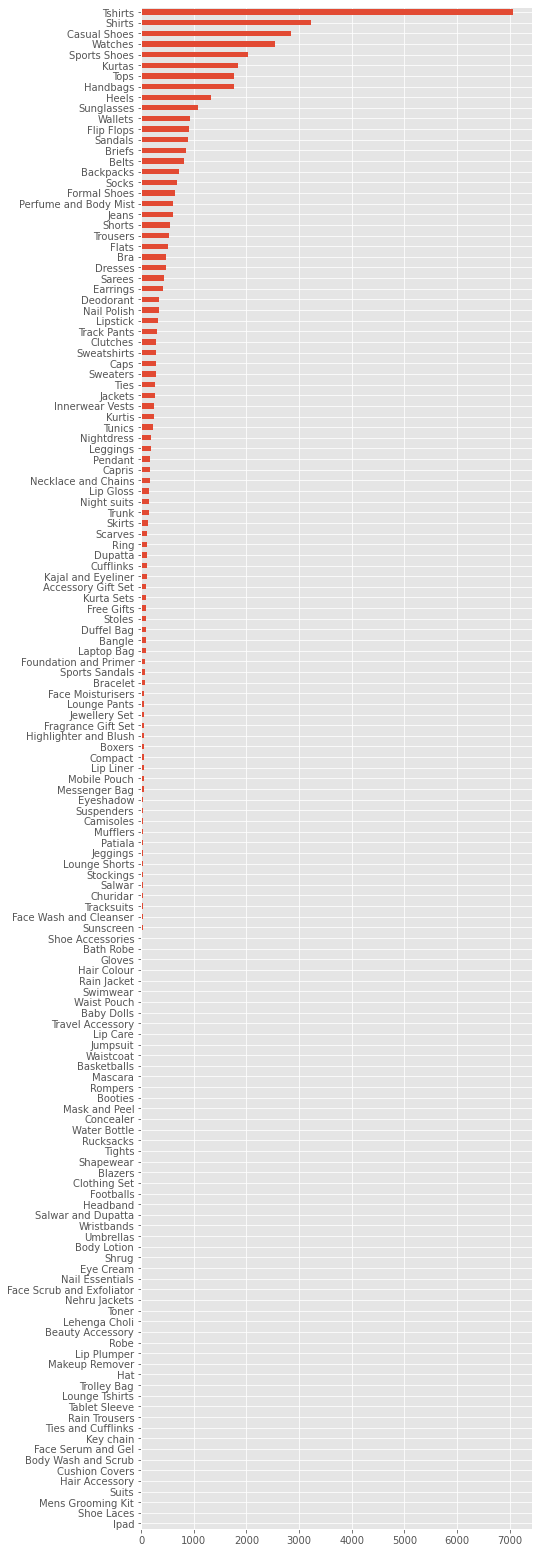

In [5]:
# Understanding the data, how many different articleType are present and knowing their frequency
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [6]:
# Creating a new column called as image which will store name of the image corresponding to that item id
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

#reseting the index
df = df.reset_index(drop=True)

In [7]:
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg

Now the dataset includes 1 additional column image where the name of image is stored.
We will create a function in the next part of the code which will help us to easily obtain the entire path of every image

## Defining functions to load image and plot

In [8]:
#image path 
def image_location(img):
    return '../input/fashion-product-images-small/images/'  + img

# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

In [9]:
def show_images(images, rows = 1, cols=1,figsize=(12, 12)):
    
    #define fig
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize=figsize)
    
    #loop for images
    for index,name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
        
    #plot
    plt.tight_layout() 

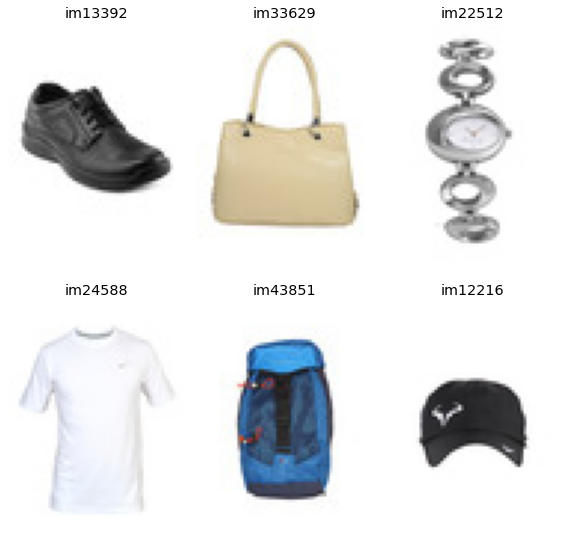

In [10]:
# Generation of a dictionary of {index, image}
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}

# Plotting the images in a figure, with 2 rows and 3 columns
show_images(figures, 2, 3)

## Creating our embeddings model

In [11]:
# Defining the input shape
width= 224
height= 224

# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = resnetmodel._modules.get('avgpool')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
#evaluate the model
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Applying embeddings on our dataset

In [13]:
# scaling the data
s_data = transforms.Scale((224, 224))

#normalizing
standardize = transforms.standardize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# converting to tensor
convert_tensor = transforms.ToTensor()

In [14]:
#missing image object
missing_img = []

In [17]:
#function to get embeddings

def vector_extraction(resnetmodel, image_id):
    
    # Using concept of exception handling to ignore missing images
    try: 
        # 1. Load the image with Pillow library
        img = Image.open(image_location(image_id)).convert('RGB')
        
        # 2. Create a PyTorch Variable with the transformed image
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        
        # 3. Create a vector of zeros that will hold our feature vector
        # The 'avgpool' layer has an output size of 512
        embeddings = torch.zeros(512)
        
        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
            
        # 5. Attach that function to our selected layer
        hlayer = layer.register_forward_hlayer(copy_data)
        
        # 6. Run the model on our transformed image
        resnetmodel(t_img)
        
        # 7. Detach our copy function from the layer
        hlayer.remove()
        emb = embeddings
        
        # 8. Return the feature vector
        return embeddings
    
    # If file not found
    except FileNotFoundError:
        # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

In [18]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

(80, 60, 3)
tensor([1.6732e-02, 9.8327e-01, 4.0268e-02, 1.1314e-01, 2.0513e-01, 1.2468e+00,
        3.5904e-02, 3.3680e-01, 1.3279e+00, 4.8053e-01, 4.5403e-02, 2.1866e-01,
        1.2002e+00, 1.2201e-01, 0.0000e+00, 9.9961e-03, 5.6686e-01, 0.0000e+00,
        1.9427e-02, 2.7316e-01, 2.9556e-01, 1.0254e+00, 1.1648e+00, 5.4014e-01,
        2.9776e-02, 1.2624e-01, 5.3572e-01, 2.1451e+00, 1.5348e-01, 3.6843e-01,
        1.1278e+00, 2.5455e-01, 2.3566e-01, 9.0818e-01, 1.4324e+00, 1.0864e+00,
        7.2151e-01, 2.8588e-01, 5.6683e-01, 7.9897e-02, 6.0556e-01, 6.3392e-02,
        2.2239e-01, 1.5460e+00, 2.6952e+00, 0.0000e+00, 4.6124e-02, 2.3475e-02,
        1.3130e+00, 5.5342e-01, 2.3303e+00, 3.7319e-01, 7.1914e-01, 4.4571e-01,
        8.5868e-01, 5.1455e-01, 4.8082e-01, 2.3485e+00, 4.6088e-01, 1.9201e+00,
        3.0348e-01, 7.3000e-01, 8.2374e-01, 5.0691e-01, 1.0031e-01, 3.2392e-02,
        5.1186e-01, 2.9504e-01, 1.7705e-01, 1.4258e+00, 4.5813e-01, 1.8374e+00,
        1.4661e-01, 6.7185e-

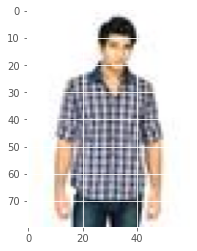

In [21]:
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_0)

In [28]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image)

(80, 60, 3)
tensor([8.1168e-02, 5.7813e-01, 4.7127e-02, 2.8967e-01, 2.9504e-01, 1.4812e+00,
        2.8125e-02, 3.3850e-02, 1.0552e+00, 1.1357e-01, 6.4070e-01, 1.5981e-01,
        3.0579e-01, 2.2309e-01, 6.3423e-02, 4.7613e-01, 3.6778e-01, 5.3658e-03,
        0.0000e+00, 8.4447e-01, 2.3644e-01, 2.5653e-01, 9.0428e-01, 9.9996e-01,
        2.3291e-01, 4.8381e-01, 3.4912e-01, 2.7443e+00, 4.9957e-02, 9.0198e-01,
        7.1699e-01, 3.8131e-01, 7.1722e-02, 1.0567e+00, 1.6030e+00, 3.5465e-01,
        1.2334e+00, 5.1008e-01, 9.6673e-01, 3.0915e-01, 9.8764e-01, 6.1991e-02,
        3.9201e-01, 1.2598e+00, 1.3397e+00, 2.9731e-01, 9.2203e-02, 0.0000e+00,
        8.7319e-01, 6.4421e-01, 2.0365e+00, 3.8533e-01, 2.2168e-01, 4.7867e-01,
        1.9393e+00, 4.6683e-01, 1.6479e+00, 9.8806e-01, 5.5426e-02, 8.7997e-01,
        4.1202e-02, 7.4618e-01, 1.0865e+00, 6.6375e-01, 2.9428e-01, 2.7977e-01,
        4.4530e-01, 1.7650e-02, 4.8383e-01, 6.9452e-01, 1.1172e+00, 9.6705e-01,
        6.2011e-01, 2.1520e-

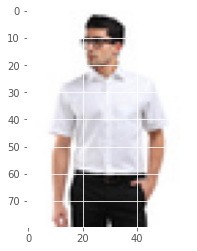

In [29]:
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(sample_embedding_1)

In [30]:
#Finding the similarity between those two images
cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0),
              sample_embedding_1.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: [[0.8811257]]



In [32]:
%%time
import swifter
 
# Applying embeddings on subset of this huge dataset
df_embeddings     = df[:5000] #We can apply on entire df, like: df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

#convert to series
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: user 10min 49s, sys: 3.65 s, total: 10min 53s
Wall time: 5min 44s


0         1         2         3         4         5         6    \
0  0.016732  0.983267  0.040268  0.113140  0.205126  1.246753  0.035904   
1  0.034120  0.804465  0.071094  0.286108  0.118644  0.485673  0.767113   
2  0.306779  0.196791  2.325818  0.337869  0.206403  0.410262  2.865744   
3  0.052566  0.312828  0.318465  0.045758  0.207992  0.486139  0.871359   
4  0.146032  0.624985  0.023857  0.201500  0.273301  2.073840  0.038832   

        7         8         9    ...       502       503       504       505  \
0  0.336803  1.327888  0.480529  ...  0.584026  0.483292  1.229778  0.738920   
1  0.116924  1.131223  1.229429  ...  0.125503  0.554490  0.160279  0.211642   
2  0.493546  2.894568  3.824196  ...  0.377007  3.216576  2.293661  1.343940   
3  0.437957  0.861973  1.257671  ...  0.000401  0.126220  0.117900  0.174461   
4  0.537267  1.338017  0.428539  ...  0.039452  1.069758  0.774631  0.874319   

        506       507       508       509       510       511  
0  0.000000  0.035314  1.740417  0.887334  0.004988  0.036427  
1  0.000000  0.921631  1.210376  0.750111  0.015514  0.182356  
2  1.047547  0.016881  2.759721  0.630303  0.114623  0.002224  
3  0.000000  0.004943  1.039022  0.150581  0.009435  0.015909  
4  0.000000  0.010583  2.638507  0.303630  0.005840  0.026666  

[5 rows x 512 columns]

## Exporting df_embs for future usage

In [ ]:
#export the embeddings 
df_embs.to_csv('df_embs.csv')

# importing the embeddings  
df_embs = pd.read_csv('df_embs.csv')
df_embs.drop(['Unnamed: 0','index'],axis=1,inplace=True)
df_embs.dropna(inplace=True)

Another method for exporting and importing df_embs is using joblib

In [ ]:
#exporting as pkl
joblib.dump(df_embs, 'df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('df_embs.pkl')

## Calculating similarity and recommending 

In [33]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs) 

# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.0000007 , 0.76683545, 0.5455518 , 0.779508  ],
       [0.76683545, 1.0000002 , 0.49617064, 0.88492715],
       [0.5455518 , 0.49617064, 0.9999991 , 0.52310663],
       [0.779508  , 0.88492715, 0.52310663, 1.000001  ]], dtype=float32)

In [34]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales

# Defining a function that gives recommendations based on the cosine similarity score
def recomend_images(ImId, df, top_n = 6):
    
    # Assigning index of reference into sim_ImId
    sim_ImId    = index_vales[ImId]
    
    # Storing cosine similarity of all other items with item requested by user in sim_scores as a list
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))
    
    # Sorting the list of sim_scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Extracting the top n values from sim_scores
    sim_scores = sim_scores[1:top_n+1]
    
    # ImId_rec will return the index of similar items
    ImId_rec    = [i[0] for i in sim_scores]
    
    # ImId_sim will return the value of similarity score
    ImId_sim    = [i[1] for i in sim_scores]
    
    return index_vales.iloc[ImId_rec].index, ImId_sim

# Sample given below
recomend_images(3810, df, top_n = 5)

(Int64Index([2400, 3899, 3678, 4818, 2354], dtype='int64'),
 [0.9632292, 0.9571406, 0.95574236, 0.9539639, 0.95376974])

## Visualizing the Recommendations

In [35]:
def Rec_viz_image(input_imageid): 

    # Getting recommendations
    idx_rec, idx_sim = recomend_images(input_imageid, df, top_n = 6)
    
    # Printing the similarity score
    print (idx_sim)
    
    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    # Generating a dictionary of { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    show_images(figures, 2, 3)
    

[0.9632292, 0.9571406, 0.95574236, 0.9539639, 0.95376974, 0.9536929]


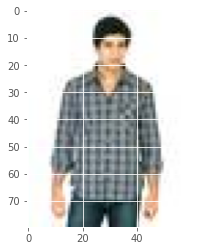

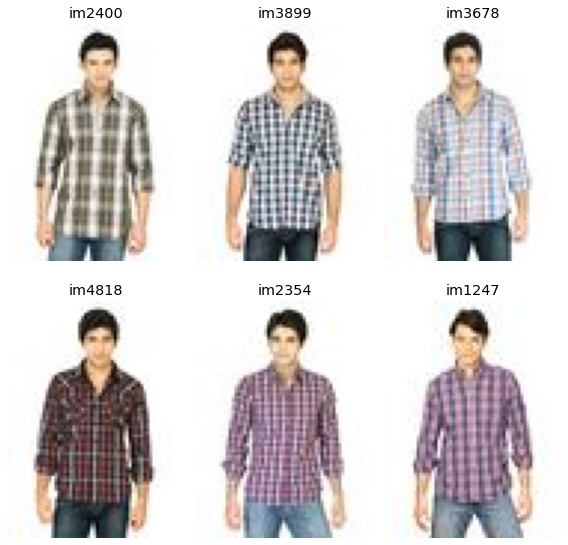

In [36]:
Rec_viz_image(3810)

[0.94663244, 0.94273376, 0.9418084, 0.9403439, 0.93752337, 0.9371748]


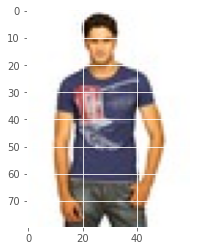

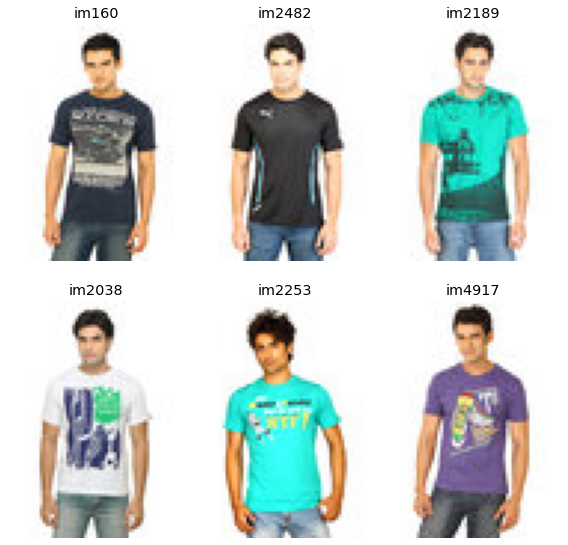

In [37]:
Rec_viz_image(1921)

[0.9506557, 0.931319, 0.928721, 0.9247011, 0.9215533, 0.917436]


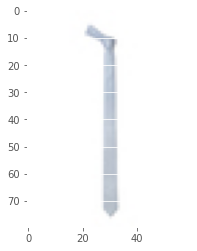

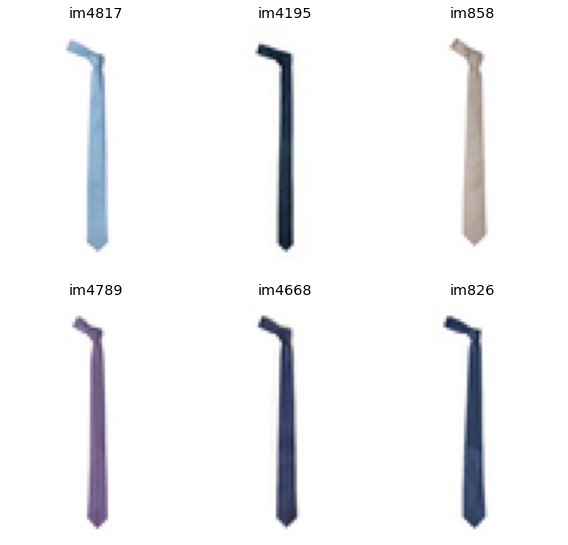

In [38]:
Rec_viz_image(2518)

[0.9653256, 0.9461927, 0.9411017, 0.93869746, 0.93791807, 0.93613046]


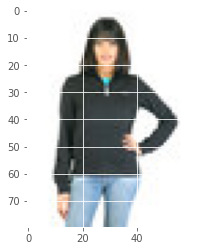

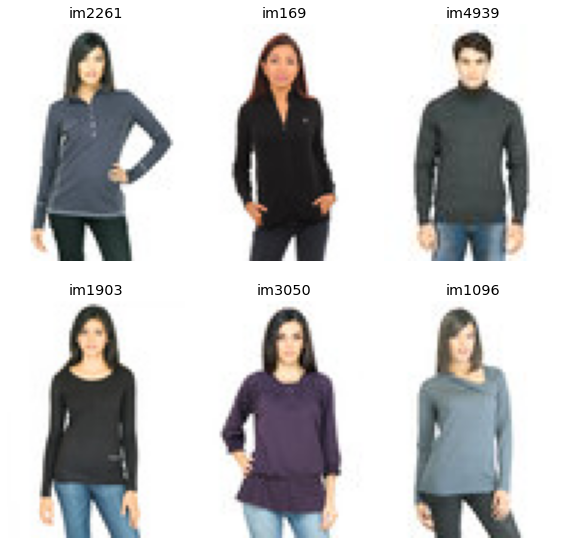

In [39]:
Rec_viz_image(1269)

[0.906932, 0.9019239, 0.9019029, 0.89966416, 0.8944635, 0.8942733]


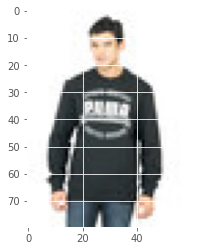

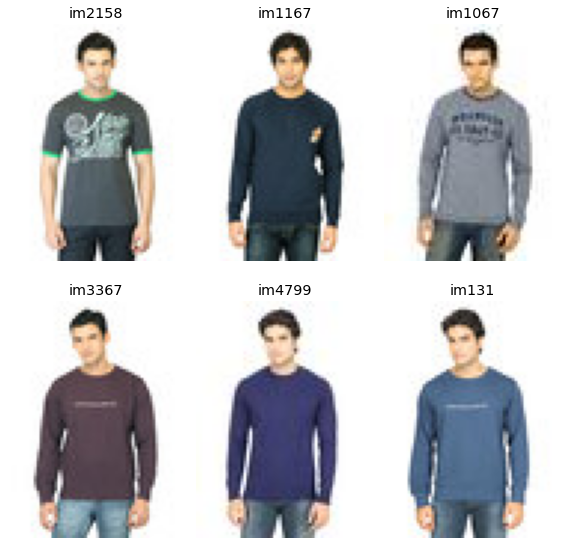

In [40]:
Rec_viz_image(1469)

[0.94526684, 0.9425344, 0.9389231, 0.93833745, 0.93381894, 0.932212]


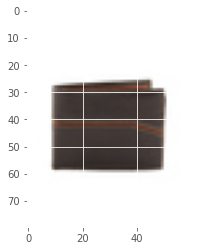

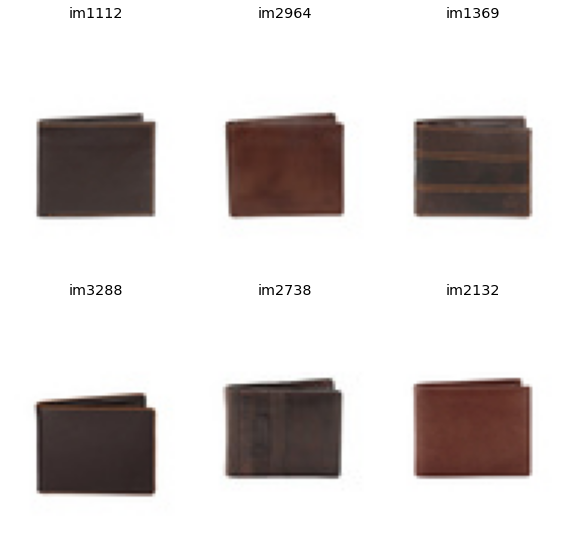

In [41]:
Rec_viz_image(2689)

[0.97269857, 0.9465234, 0.944247, 0.94181484, 0.9382513, 0.9371736]


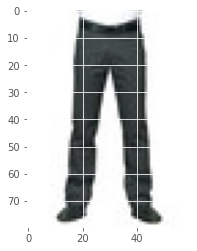

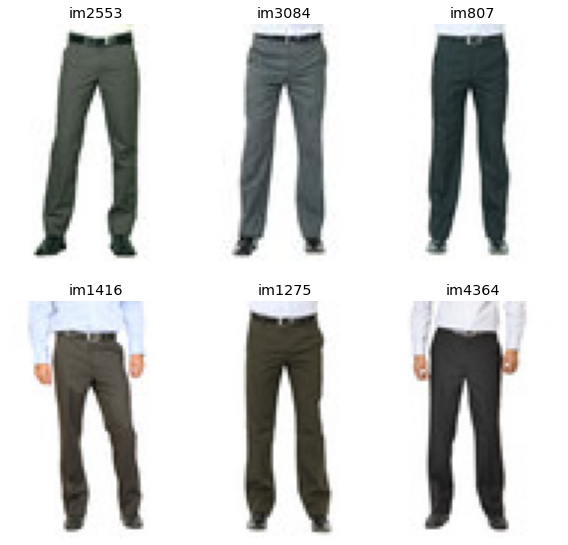

In [42]:
Rec_viz_image(2001)

## Taking image input from User and Recommending Similar Products

4320    0.744881
1581    0.733496
2462    0.732663
1395    0.729467
3606    0.729427
1652    0.729389
1501    0.728551
784     0.728256
1073    0.728141
4541    0.728000
Name: Score, dtype: float64


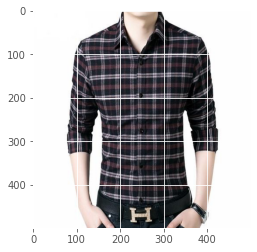

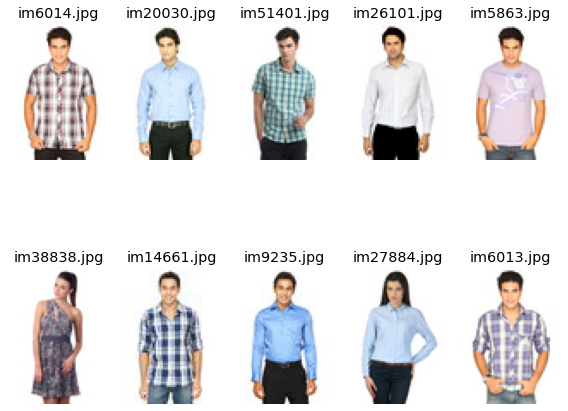

In [51]:
def recm_user_input(image_id):
    
    # Loading image and reshaping it
    img = Image.open('../input/testset-for-image-similarity/' + image_id).convert('RGB')
    
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
    
    # 3. Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    embeddings = torch.zeros(512)
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
         embeddings.copy_(o.data.reshape(o.data.size(1)))
            
    # 5. Attach that function to our selected layer
    hlayer = layer.register_forward_hlayer(copy_data)
    
    # 6. Run the model on our transformed image
    resnetmodel(t_img)
    
    # 7. Detach our copy function from the layer
    hlayer.remove()
    emb = embeddings
    
    
    # Calculating Cosine Similarity
    cs = cosine_similarity(emb.unsqueeze(0),df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)
    
    # Printing Cosine Similarity
    print(cs_df['Score'][:10])
    
    # Extracting the index of top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index==i]['image']
        images_list.append(image_id)
    images_list = list(flatten(images_list))
    
    # Plotting the image of item requested by user
    img_print = Image.open('../input/testset-for-image-similarity/' + image_id)
    plt.imshow(img_print)

    # Generating a dictionary { index, image }
    figures = {'im'+str(i): Image.open('../input/fashion-product-images-small/images/' + i) for i in images_list}
    
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout() 

recm_user_input('test2.jpg')

4036    0.824246
954     0.810449
3268    0.808926
4528    0.808186
3299    0.807687
295     0.806027
1978    0.805003
2900    0.803676
3688    0.800311
1229    0.800130
Name: Score, dtype: float64


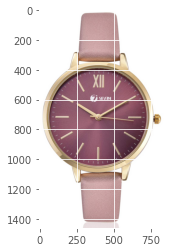

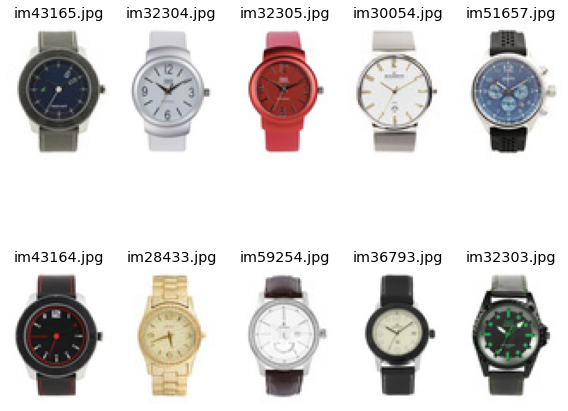

In [52]:
recm_user_input('test5.jpg')

4073    0.751081
3377    0.739944
2303    0.739483
487     0.725723
2291    0.716327
3209    0.712455
685     0.712455
4789    0.707857
3745    0.704858
4990    0.702923
Name: Score, dtype: float64


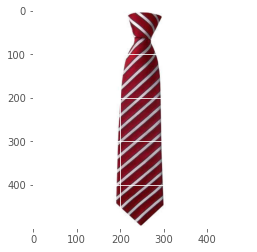

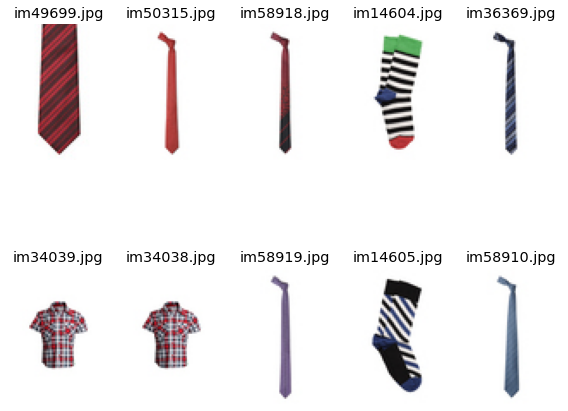

In [53]:
recm_user_input('test6.jpg')

3377    0.804317
3160    0.798793
1573    0.798653
2303    0.796408
1602    0.756025
858     0.749575
4789    0.746661
4990    0.745834
2991    0.742408
1814    0.735739
Name: Score, dtype: float64


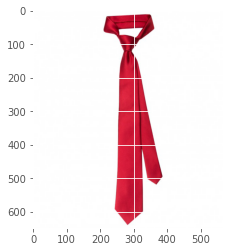

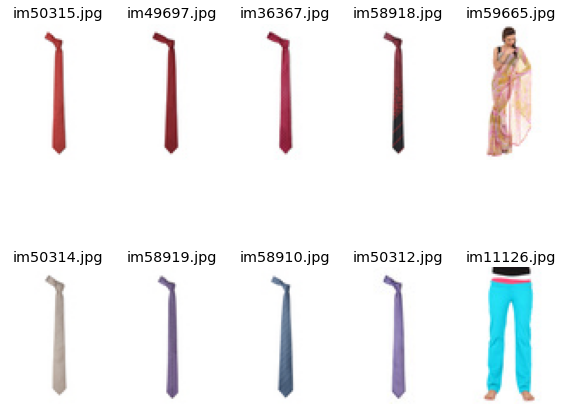

In [54]:
recm_user_input('test7.jpg')

4874    0.787595
1625    0.781200
2114    0.776908
3144    0.773119
3768    0.772340
1005    0.772147
1478    0.769806
4890    0.767647
4600    0.767490
1249    0.765223
Name: Score, dtype: float64


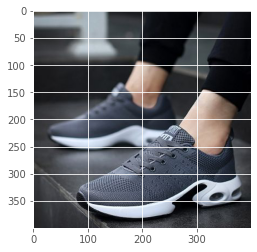

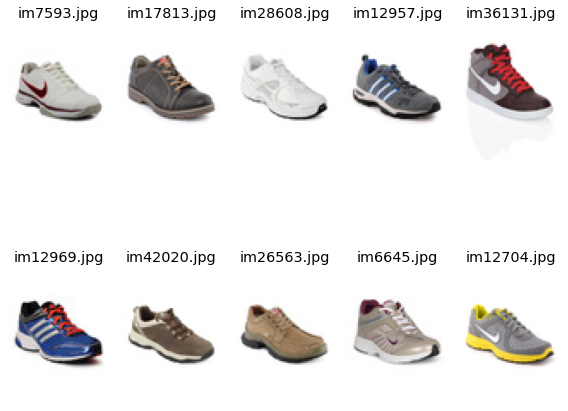

In [55]:
recm_user_input('test14.jpg')

3061    0.839918
940     0.836152
1264    0.832152
3817    0.821513
2964    0.817163
111     0.813732
3288    0.813705
1666    0.813388
3403    0.812319
831     0.812011
Name: Score, dtype: float64


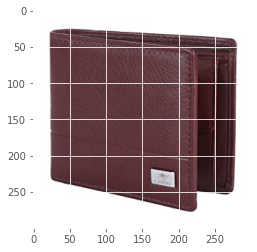

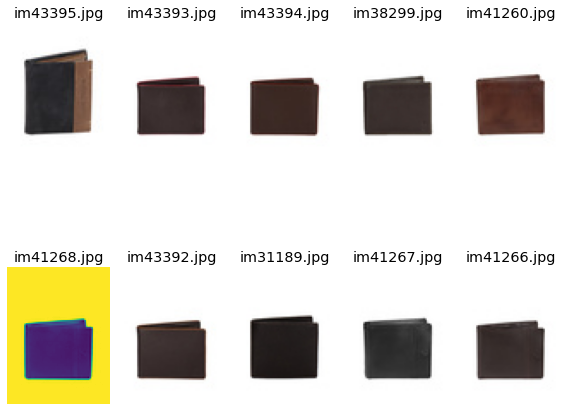

In [56]:
recm_user_input('test18.jpg')

4780    0.801703
3113    0.799940
1126    0.794135
3143    0.791237
4739    0.781778
3425    0.780110
3913    0.779828
4822    0.777540
1291    0.773518
2935    0.772801
Name: Score, dtype: float64


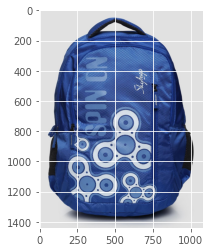

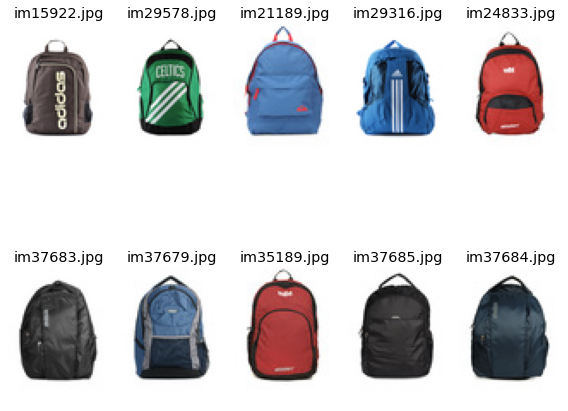

In [57]:
recm_user_input('test19.jpg')

3957    0.898339
274     0.897223
3060    0.893657
607     0.887017
3799    0.886672
760     0.884524
3894    0.882573
3137    0.880227
185     0.878899
3752    0.876327
Name: Score, dtype: float64


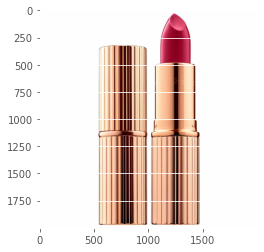

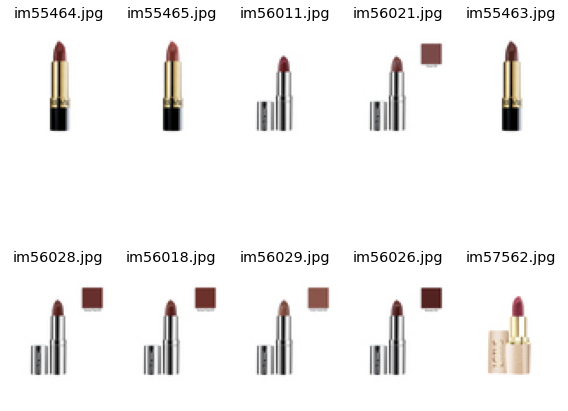

In [58]:
recm_user_input('test21.jpg')